In [1]:
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from scipy.spatial.distance import cosine
from scipy.stats import entropy

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings("ignore")

In [2]:
DATA_PATH = r"C:/Users/LENOVO/Desktop/ByteBuzz/Data/final_dataset.csv"
MODEL_DIR = r"C:/Users/LENOVO/Desktop/ByteBuzz/models"
RESULTS_DIR = r"C:/Users/LENOVO/Desktop/ByteBuzz/results"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Hyperparams
EPOCHS = 40
BATCH_SIZE = 128
LR = 1e-3
EMB_DIM = 128
PROJ_DIM = 64
TEMPERATURE = 0.5
SEED = 42
p_dropout = 0.2  # modality dropout probability
pretrain = True 

torch.manual_seed(SEED)
np.random.seed(SEED)


In [4]:
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"{DATA_PATH} not found")

df = pd.read_csv(DATA_PATH)
labels = df["Label"].values

EEG_cols  = [c for c in df.columns if c.startswith("EEG_PC")]
EYE_cols  = [c for c in df.columns if c.startswith("EYE_PC")]
GSR_cols  = [c for c in df.columns if c.startswith("GSR_PC")]
IVT_cols  = [c for c in df.columns if c.startswith("IVT_PC")]
TIVA_cols = [c for c in df.columns if c.startswith("TIVA_PC")]

pairs = [
    ("EEG","EYE", EEG_cols, EYE_cols),
    ("EEG","GSR", EEG_cols, GSR_cols),
    ("EEG","TIVA", EEG_cols, TIVA_cols),
    ("EEG","IVT", EEG_cols, IVT_cols),
]

print("Pairs to run:", [(a,b,len(src),len(tgt)) for (a,b,src,tgt) in pairs])


Pairs to run: [('EEG', 'EYE', 7, 3), ('EEG', 'GSR', 7, 4), ('EEG', 'TIVA', 7, 5), ('EEG', 'IVT', 7, 6)]


In [5]:
# Models

class EncoderMLP(nn.Module):
    def __init__(self, input_dim, emb_dim=EMB_DIM):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, emb_dim)
        )
    def forward(self, x):
        return self.net(x)

class ProjectionHead(nn.Module):
    def __init__(self, in_dim=EMB_DIM, proj_dim=PROJ_DIM):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Linear(256, proj_dim)
        )
    def forward(self, x):
        return self.net(x)


# Optional EEG pretraining

pretrained_enc_s = None
if pretrain and len(EEG_cols)>0:
    print("Pretraining EEG encoder...")
    X_eeg = df[EEG_cols].fillna(0).values
    scaler_eeg = StandardScaler().fit(X_eeg)
    X_eeg_s = scaler_eeg.transform(X_eeg)

    ds = TensorDataset(torch.tensor(X_eeg_s,dtype=torch.float32))
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

    enc_s = EncoderMLP(len(EEG_cols)).to(DEVICE)
    optimizer = torch.optim.Adam(enc_s.parameters(), lr=LR)
    for epoch in range(5):  # light pretraining
        tot_loss = 0
        for (x,) in loader:
            x = x.to(DEVICE)
            z = enc_s(x)
            loss = ((z - z.mean(0))**2).mean()  # variance loss
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            tot_loss += loss.item()
        print(f"EEG pretrain epoch {epoch+1}/5 loss={tot_loss/len(loader):.4f}")
    pretrained_enc_s = enc_s.state_dict()
    joblib.dump(scaler_eeg, os.path.join(MODEL_DIR,"pretrain_scaler_eeg.pkl"))
    torch.save(enc_s.state_dict(), os.path.join(MODEL_DIR,"pretrain_enc_eeg.pth"))
    print("EEG pretraining done.")


Pretraining EEG encoder...
EEG pretrain epoch 1/5 loss=0.0191
EEG pretrain epoch 2/5 loss=0.0056
EEG pretrain epoch 3/5 loss=0.0034
EEG pretrain epoch 4/5 loss=0.0021
EEG pretrain epoch 5/5 loss=0.0015
EEG pretraining done.


In [6]:
# Training + evaluation

def train_contrastive_pair_safe(df, source_cols, target_cols, pair_name):
    Xs = df[source_cols].fillna(0).values
    Xt = df[target_cols].fillna(0).values
    scaler_s = StandardScaler().fit(Xs)
    scaler_t = StandardScaler().fit(Xt)
    Xs_s = scaler_s.transform(Xs)
    Xt_s = scaler_t.transform(Xt)

    ds = TensorDataset(torch.tensor(Xs_s,dtype=torch.float32), torch.tensor(Xt_s,dtype=torch.float32))
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

    enc_s = EncoderMLP(Xs_s.shape[1]).to(DEVICE)
    if pretrained_enc_s is not None and source_cols==EEG_cols:
        enc_s.load_state_dict(pretrained_enc_s)
    enc_t = EncoderMLP(Xt_s.shape[1]).to(DEVICE)
    proj_s = ProjectionHead(EMB_DIM, PROJ_DIM).to(DEVICE)
    proj_t = ProjectionHead(EMB_DIM, PROJ_DIM).to(DEVICE)

    optimizer = torch.optim.Adam(list(enc_s.parameters())+list(enc_t.parameters())+
                                 list(proj_s.parameters())+list(proj_t.parameters()), lr=LR)

    best_loss = float("inf")
    for epoch in range(1, EPOCHS+1):
        enc_s.train(); enc_t.train(); proj_s.train(); proj_t.train()
        tot_loss = 0.0; n=0
        for xa, xb in loader:
            xa, xb = xa.to(DEVICE), xb.to(DEVICE)

            # Modality dropout
            mask_xa = torch.rand_like(xa) > p_dropout
            mask_xb = torch.rand_like(xb) > p_dropout
            xa = xa * mask_xa
            xb = xb * mask_xb

            za = enc_s(xa); zb = enc_t(xb)
            pa = proj_s(za); pb = proj_t(zb)
            pa = pa / (pa.norm(dim=1, keepdim=True)+1e-8)
            pb = pb / (pb.norm(dim=1, keepdim=True)+1e-8)

            N = pa.size(0)
            z = torch.cat([pa, pb], dim=0)
            sim = torch.matmul(z, z.T) / TEMPERATURE
            mask = (~torch.eye(2*N, dtype=torch.bool, device=sim.device)).float()
            exp_sim = torch.exp(sim) * mask
            denom = exp_sim.sum(dim=1, keepdim=True)
            positives = torch.cat([torch.sum(pa*pb,dim=1), torch.sum(pb*pa,dim=1)], dim=0).unsqueeze(1)
            loss_v = -torch.log(torch.exp(positives/TEMPERATURE) / denom)
            loss = loss_v.mean()

            optimizer.zero_grad(); loss.backward(); optimizer.step()
            tot_loss += loss.item(); n+=1

        avg_loss = tot_loss/max(1,n)
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(enc_s.state_dict(), os.path.join(MODEL_DIR, f"{pair_name}_enc_s.pth"))
            torch.save(enc_t.state_dict(), os.path.join(MODEL_DIR, f"{pair_name}_enc_t.pth"))
            torch.save(proj_s.state_dict(), os.path.join(MODEL_DIR, f"{pair_name}_proj_s.pth"))
            torch.save(proj_t.state_dict(), os.path.join(MODEL_DIR, f"{pair_name}_proj_t.pth"))
            joblib.dump(scaler_s, os.path.join(MODEL_DIR, f"{pair_name}_scaler_s.pkl"))
            joblib.dump(scaler_t, os.path.join(MODEL_DIR, f"{pair_name}_scaler_t.pkl"))
        if epoch%10==0 or epoch==1:
            print(f"[{pair_name}] Epoch {epoch}/{EPOCHS} avg_loss={avg_loss:.4f} best={best_loss:.4f}")

    print(f"[{pair_name}] Done. Best loss {best_loss:.4f}")
    return {
        "enc_s": os.path.join(MODEL_DIR, f"{pair_name}_enc_s.pth"),
        "enc_t": os.path.join(MODEL_DIR, f"{pair_name}_enc_t.pth"),
        "proj_s": os.path.join(MODEL_DIR, f"{pair_name}_proj_s.pth"),
        "proj_t": os.path.join(MODEL_DIR, f"{pair_name}_proj_t.pth"),
        "scaler_s": os.path.join(MODEL_DIR, f"{pair_name}_scaler_s.pkl"),
        "scaler_t": os.path.join(MODEL_DIR, f"{pair_name}_scaler_t.pkl")
    }

def eval_contrastive_checkpoint_safe(pair_name, target_cols):
    scaler_t_path = os.path.join(MODEL_DIR, f"{pair_name}_scaler_t.pkl")
    enc_t_path = os.path.join(MODEL_DIR, f"{pair_name}_enc_t.pth")
    proj_t_path = os.path.join(MODEL_DIR, f"{pair_name}_proj_t.pth")
    if not (os.path.exists(scaler_t_path) and os.path.exists(enc_t_path) and os.path.exists(proj_t_path)):
        print("Missing artifacts for", pair_name)
        return None, None
    scaler_t = joblib.load(scaler_t_path)
    enc_t = EncoderMLP(len(target_cols), EMB_DIM)
    proj_t = ProjectionHead(EMB_DIM, PROJ_DIM)
    enc_t.load_state_dict(torch.load(enc_t_path, map_location="cpu"))
    proj_t.load_state_dict(torch.load(proj_t_path, map_location="cpu"))
    enc_t.eval(); proj_t.eval()

    Xt = df[target_cols].fillna(0).values
    Xt_s = scaler_t.transform(Xt)
    with torch.no_grad():
        emb = enc_t(torch.tensor(Xt_s.astype(np.float32))).numpy()
        proj = proj_t(torch.tensor(emb.astype(np.float32))).numpy()
        proj = proj / (np.linalg.norm(proj, axis=1, keepdims=True)+1e-8)

    # downstream RF
    Xtr, Xte, ytr, yte = train_test_split(proj, labels, test_size=0.2, stratify=labels, random_state=42)
    clf = RandomForestClassifier(n_estimators=200, random_state=42)
    clf.fit(Xtr, ytr)
    preds = clf.predict(Xte)
    acc = accuracy_score(yte, preds)
    f1 = f1_score(yte, preds, average="weighted")

    # Domain similarity (only if same size)
    if len(target_cols)==len(EEG_cols):
        eeg_mean = df[EEG_cols].fillna(0).values.mean(axis=0)
        emb_mean = Xt_s.mean(axis=0)
        cos_sim = 1 - cosine(emb_mean, eeg_mean)
        p = emb_mean / (emb_mean.sum() + 1e-10)
        q = eeg_mean / (eeg_mean.sum() + 1e-10)
        kl_div = entropy(p, q)
        print(f"{pair_name}: Cosine similarity={cos_sim:.3f}, KL divergence={kl_div:.3f}")
    else:
        print(f"{pair_name}: Skipping cosine/KL due to mismatched feature sizes ({len(target_cols)} vs {len(EEG_cols)})")

    return acc, f1


In [7]:
# Run all pairs and save CSV

results = []
for src_name, tgt_name, src_cols, tgt_cols in pairs:
    if len(src_cols)==0 or len(tgt_cols)==0:
        print(f"Skipping {src_name}->{tgt_name}: empty cols")
        continue
    pair_name = f"{src_name.lower()}2{tgt_name.lower()}"
    print("\nRunning:", pair_name)
    _ = train_contrastive_pair_safe(df, src_cols, tgt_cols, pair_name)
    acc, f1 = eval_contrastive_checkpoint_safe(pair_name, tgt_cols)
    if acc is not None:
        results.append({"Modality":tgt_name,"Pair":pair_name,"Acc":acc,"F1":f1})
        print(f"{pair_name}: Acc={acc:.3f}, F1={f1:.3f}")
    else:
        print(f"{pair_name}: evaluation skipped (missing artifacts)")

contrastive_csv = os.path.join(RESULTS_DIR,"contrastive_results.csv")
pd.DataFrame(results).to_csv(contrastive_csv, index=False)
print("Saved contrastive_results.csv ->", contrastive_csv)



Running: eeg2eye
[eeg2eye] Epoch 1/40 avg_loss=5.7384 best=5.7384
[eeg2eye] Epoch 10/40 avg_loss=5.4209 best=5.4209
[eeg2eye] Epoch 20/40 avg_loss=5.2924 best=5.2631
[eeg2eye] Epoch 30/40 avg_loss=5.2219 best=5.2199
[eeg2eye] Epoch 40/40 avg_loss=5.1906 best=5.1580
[eeg2eye] Done. Best loss 5.1580
eeg2eye: Skipping cosine/KL due to mismatched feature sizes (3 vs 7)
eeg2eye: Acc=0.752, F1=0.693

Running: eeg2gsr
[eeg2gsr] Epoch 1/40 avg_loss=5.6779 best=5.6779
[eeg2gsr] Epoch 10/40 avg_loss=5.3436 best=5.3436
[eeg2gsr] Epoch 20/40 avg_loss=5.2024 best=5.1776
[eeg2gsr] Epoch 30/40 avg_loss=5.1228 best=5.1083
[eeg2gsr] Epoch 40/40 avg_loss=5.0413 best=5.0413
[eeg2gsr] Done. Best loss 5.0413
eeg2gsr: Skipping cosine/KL due to mismatched feature sizes (4 vs 7)
eeg2gsr: Acc=0.752, F1=0.693

Running: eeg2tiva
[eeg2tiva] Epoch 1/40 avg_loss=5.7009 best=5.7009
[eeg2tiva] Epoch 10/40 avg_loss=5.3421 best=5.3421
[eeg2tiva] Epoch 20/40 avg_loss=5.1984 best=5.1984
[eeg2tiva] Epoch 30/40 avg_loss=5

# Visualization

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

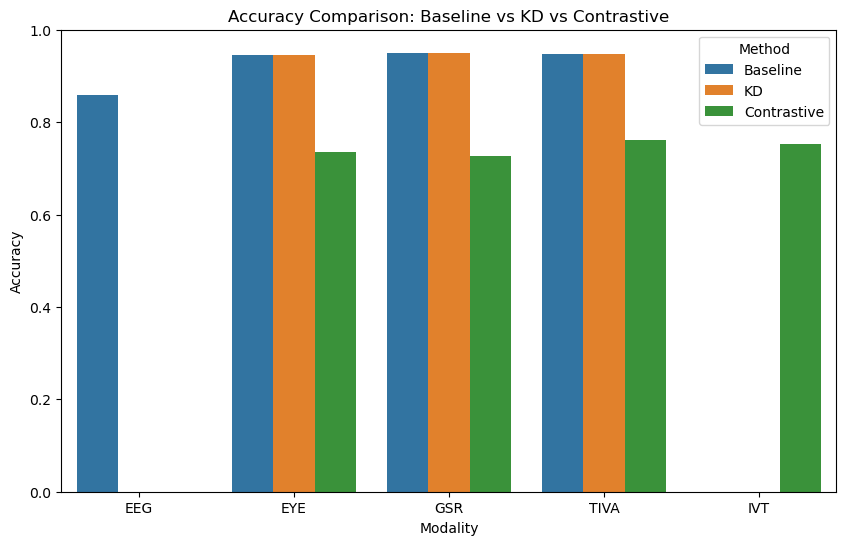

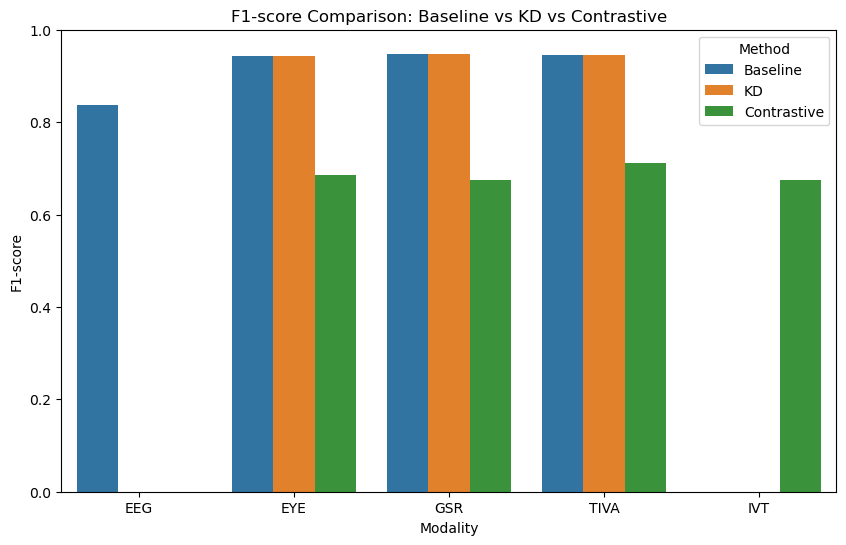

In [9]:
df = pd.read_csv("C:/Users/LENOVO/Desktop/IITB/results/combined_results_all.csv")

# 1) Accuracy comparison
plt.figure(figsize=(10,6))
sns.barplot(x="Modality", y="Acc", hue="Method", data=df)
plt.title("Accuracy Comparison: Baseline vs KD vs Contrastive")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.legend(title="Method")
plt.show()

# 2) F1-score comparison
plt.figure(figsize=(10,6))
sns.barplot(x="Modality", y="F1", hue="Method", data=df)
plt.title("F1-score Comparison: Baseline vs KD vs Contrastive")
plt.ylabel("F1-score")
plt.ylim(0,1)
plt.legend(title="Method")
plt.show()
